/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:76: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


<IPython.core.display.Javascript object>


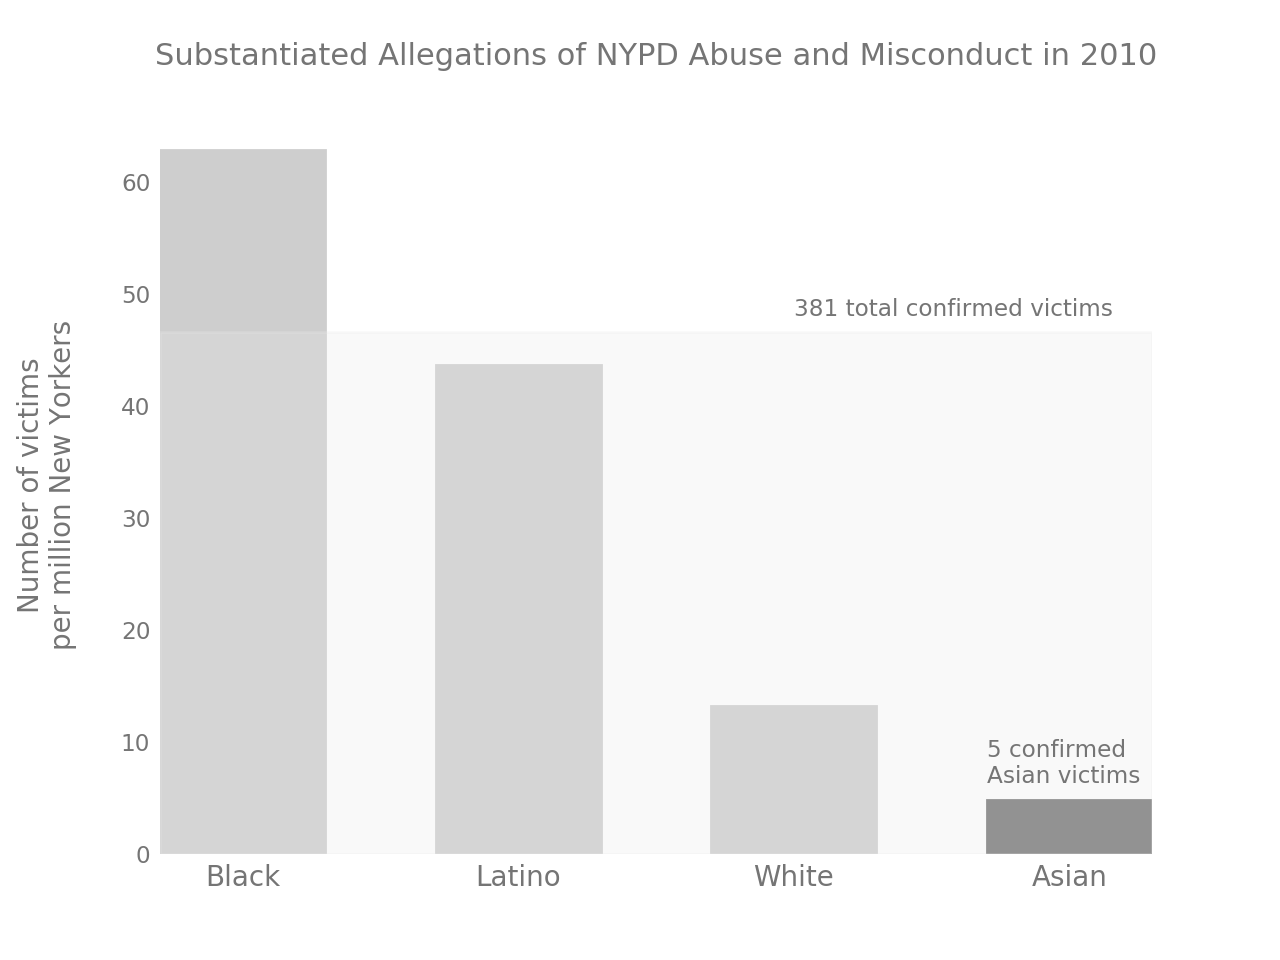

In [91]:
%matplotlib notebook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#read in CCRB data
victims = pd.read_csv('https://data.cityofnewyork.us/api/views/mvhn-ypfv/rows.csv?accessType=DOWNLOAD')


#read in demographic data from 2010 census
demos = pd.read_excel('http://www1.nyc.gov/assets/planning/download/office/data-maps/nyc-population/census2010/t_pl_p3_nyc.xlsx', 
                     header=5)

#hardcoding the total population, taken from demo data
total_population = 8175133

#fix typo in CCRB labeling
def correct_Asain(x):
    if x == 'Asain':
        return 'Asian'
    else:
        return x
    
#sync census race labels with ccrb race labels
def sync_index(x):
    
    #census data does not use 'Latino' label
    #rather, census categorizes all races as Hispanic and non-Hispanic
    #here I have labeled all 'Hispanic' as 'Latino'
    #Please note that this is NOT a perfect solution!
    if 'Hispanic' in x:
        return 'Latino'
    if x in weighted.index:
        return x
    if x not in weighted.index:
        for i in weighted.index:
            if i in x:
                return i
        return x
    
#select 2010 CCRB data, because census is from 2010, and transpose the data    
weighted = victims[victims['Year']==2010].transpose()

#'Year' data is irrelevant because we are only looking at 1 year
weighted = weighted.drop(['Year'])

#name the only remaining column of CCRB data
weighted.columns = ['victims']

#fix typo in CCRB data
weighted.index = weighted.index.map(correct_Asain)

#save total number of victims 
total_victims = weighted.victims.sum()

#drop rows non-specific race rows
weighted = weighted.drop(['Other', 'Unknown'])

#select 3rd row below header, and transpose it
demos = demos.iloc[2].transpose()

#sync racial categories in index
demos.index = demos.index.map(sync_index)

#add racial census data to new column in weighted dataframe
weighted['totalpop'] = demos

#calculate victims per million new yorkers
weighted['permill'] = weighted['victims']/(weighted['totalpop']/1000000)

#copy index to its own column
weighted['race'] = weighted.index

#sort dataframe from highest number of victims per million
weighted = weighted.sort('permill', ascending=False)

#pre-set several shades of gray to use in plot
dark_grey = '#757575'
med_grey = '#cecece'
light_grey = '#eaeaea'

#use pandas to create bar chart
weighted.plot('race', 'permill', kind='bar', 
              color=med_grey, width=.6, 
              picker=5, legend=None)

#get current axis
ax = plt.gca()

#set title
ax.set_title('Substantiated Allegations of NYPD Abuse and Misconduct in 2010\n',
             fontsize=11, 
             color=dark_grey)

#make x-ticks horizontal
plt.xticks(rotation='horizontal')

#remove x-axis label
ax.set_xlabel('')

#set y-axis label
ax.set_ylabel('Number of victims\nper million New Yorkers\n', color=dark_grey)

#remove spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

#make tick-marks invisible
ax.tick_params(axis='both', length=0)

#set color of x-axis labels for bars
for t in ax.xaxis.get_ticklabels():
    t.set_color(dark_grey)
    
#set color and size for tick labels on y-axis
for t in ax.yaxis.get_ticklabels():
    t.set_color(dark_grey)
    t.set_fontsize('small')
    
#set limits for x-axis
plt.xlim([-.3,3.3])

#calculate total number of victims per million New Yorkers
overall_permill = total_victims/(total_population/1000000)

#plot overall_permill as span
plt.axhspan(0, overall_permill, color=light_grey, alpha=.25)

#label overall_permill span
ax.text(2, overall_permill + 1.5, 
            '{} total confirmed victims'.format(total_victims), 
            color=dark_grey, fontsize='small')

#create list labels for each bar, to display actual number of victims
#set to invisible
labels=[]
for i in range (0, len(weighted.index)):
    child = ax.get_children()[i]
    
    #change 'White' to 'white' for label
    #capitalization of 'White' carries racist associations
    if weighted.iloc[i]['race'] == 'White':
        race_decap = 'white'
    else:
        race_decap = weighted.iloc[i]['race']
    label = ax.text(child.get_x(), child.get_height() + 1.5, 
            '{} confirmed\n{} victims'.format(weighted.iloc[i]['victims'], race_decap), 
            color=dark_grey, fontsize='small', visible=False)
    labels.append(label)


def onpick(event):
    
    #save selected artist and its height
    selected_artist = event.artist
    selected_permill = selected_artist.get_height()
    
    #reset all bars to medium grey
    for i in range (0, len(weighted.index)):
        ax.get_children()[i].set_color(med_grey)
        
    #set selected bar to dark grey    
    selected_artist.set_color(dark_grey)
    
    #get race which selected bar refers to
    filtered = weighted[weighted['permill']==selected_permill]
    race = filtered.iloc[0,3]
    
    #get index position of selected race in weighted df
    position = weighted.index.get_loc(race)

    #reset all labels to invisible
    for i in labels:
        i.set_visible(False)
    
    #make selected bar's label visible
    labels[position].set_visible(True)

    
#link pick event
plt.gcf().canvas.mpl_connect('pick_event', onpick)

#show plot
plt.show()
